# Feature Engineering And Modelling

## Considering Churn Drivers
In the previous task, we found a few features that could be possible drivers for customer attrition. Those features were electricity consumption over the past 12 months, cons_12m, gas consumption over the past 12 months, cons_gas_12m, net margin on power subscription, margin_net_pow_ele, and subscribed power, pow_max.

Other features that could help predict churn are:

    1. channel_sales: code of the sales channel
    2. imp_cons: current paid consumption
    3. origin_up: code of the electricity campaign the customer first subscribed to
    4. price_p3_fix: price of power for the third period
    
Feature selection and engineering is an iterative process. You will never have all the features to perfectly predict something, which is why it is very important to experiment different features.

### Feature engineering ideas:

Get differences in dates (contract duration, etc.)
Exctract date feature informations (year, month, dow)
Find contract length (date end - date active)
Create bins for numerical features (quantiles)

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.decomposition import PCA
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [2]:
df = pd.read_csv('./Client_data_cleaned.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')
df["price_date"] = pd.to_datetime(df["price_date"], format='%Y-%m-%d')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_var,price_fix,total_cons
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,0.100302,27.043980,54946
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,0.100302,27.043980,54946
2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,0.100302,27.043978,54946


## Preprocessing
#### Categorical Features

In [42]:
# Get object columns
obj_to_convert = [col for col in df.columns if df[col].dtype == 'object']

# Convert to type category
df[obj_to_convert] = df[obj_to_convert].apply(lambda x: x.astype('category'))

# Conversion confirmation
for col in obj_to_convert:
    assert df[col].dtype == 'category'

In [43]:
#Changing hashed values to meaningful labels for easy understanding.
print('Unique Sales Channels : \n',df.channel_sales.unique())
print('\nUnique Origin Campaign : \n',df.origin_up.unique())

Unique Sales Channels : 
 ['foosdfpfkusacimwkcsosbicdxkicaua', 'MISSING', 'lmkebamcaaclubfxadlmueccxoimlema', 'usilxuppasemubllopkaafesmlibmsdf', 'ewpakwlliwisiwduibdlfmalxowmwpci', 'epumfxlbckeskwekxbiuasklxalciiuu', 'sddiedcslfslkckwlfkdpoeeailfpeds', 'fixdbufsefwooaasfcxdxadsiekoceaa']
Categories (8, object): ['MISSING', 'epumfxlbckeskwekxbiuasklxalciiuu', 'ewpakwlliwisiwduibdlfmalxowmwpci', 'fixdbufsefwooaasfcxdxadsiekoceaa', 'foosdfpfkusacimwkcsosbicdxkicaua', 'lmkebamcaaclubfxadlmueccxoimlema', 'sddiedcslfslkckwlfkdpoeeailfpeds', 'usilxuppasemubllopkaafesmlibmsdf']

Unique Origin Campaign : 
 ['lxidpiddsbxsbosboudacockeimpuepw', 'kamkkxfxxuwbdslkwifmmcsiusiuosws', 'ldkssxwpmemidmecebumciepifcamkci', 'MISSING', 'usapbepcfoloekilkwsdiboslwaxobdp', 'ewxeelcelemmiwuafmddpobolfuxioce']
Categories (6, object): ['MISSING', 'ewxeelcelemmiwuafmddpobolfuxioce', 'kamkkxfxxuwbdslkwifmmcsiusiuosws', 'ldkssxwpmemidmecebumciepifcamkci', 'lxidpiddsbxsbosboudacockeimpuepw', 'usapbepcfoloekilkwsdi

In [44]:
pd.DataFrame({'Channel Sales':df.channel_sales.value_counts(normalize=True)})

,Channel Sales
foosdfpfkusacimwkcsosbicdxkicaua,0.462298
MISSING,0.255120
lmkebamcaaclubfxadlmueccxoimlema,0.126207
usilxuppasemubllopkaafesmlibmsdf,0.094126
ewpakwlliwisiwduibdlfmalxowmwpci,0.061159
sddiedcslfslkckwlfkdpoeeailfpeds,0.000748
epumfxlbckeskwekxbiuasklxalciiuu,0.000206
fixdbufsefwooaasfcxdxadsiekoceaa,0.000137


In [45]:
pd.DataFrame({'Origin Up':df.origin_up.value_counts(normalize=True)})

,Origin Up
lxidpiddsbxsbosboudacockeimpuepw,0.485792
kamkkxfxxuwbdslkwifmmcsiusiuosws,0.294052
ldkssxwpmemidmecebumciepifcamkci,0.215571
MISSING,0.004379
usapbepcfoloekilkwsdiboslwaxobdp,0.000137
ewxeelcelemmiwuafmddpobolfuxioce,0.000069


## Feature engineering
#### Numerical features

In [46]:
# Checking variation
df.select_dtypes(exclude='category').var().sort_values(ascending=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13172\1761823980.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.select_dtypes(exclude='category').var().sort_values(ascending=False)


total_cons                         4.467565e+11
cons_12m                           3.289497e+11
cons_gas_12m                       2.654945e+10
cons_last_month                    4.144365e+09
forecast_cons_year                 1.055166e+07
forecast_cons_12m                  5.700444e+06
days_since_modif_prod              7.127210e+05
next_renewal                       3.703041e+05
contract_duration                  3.659012e+05
imp_cons                           1.165724e+05
net_margin                         9.724840e+04
forecast_meter_rent_12m            4.375028e+03
margin_gross_pow_ele               4.094342e+02
margin_net_pow_ele                 4.093981e+02
price_p1_p2_fix_diff               1.935581e+02
pow_max                            1.832181e+02
price_peak_fix                     1.472146e+02
price_p1_p3_fix_diff               1.060569e+02
price_mid_peak_fix                 6.118760e+01
price_fix                          4.068471e+01
forecast_discount_energy           2.610

Seems like the features that have to do anything with consumption have incredibly high variance. If we leave this as is, our model will not perform well since the data will not be in the same numerical space.

In [47]:
#features=['total_cons','cons_12m','cons_last_month','forecast_cons_year','forecast_cons_12m','imp_cons','net_margin','forecast_meter_rent_12m','margin_gross_pow_ele','margin_net_pow_ele','pow_max']
def get_percentiles(col, q):
    df[f'{col}_binned'] = pd.qcut(df[col], q=q)
    return df
    
# Getting bins for features with highest variance
df = get_percentiles('total_cons', 10)
df = get_percentiles('cons_12m', 10)
df = get_percentiles('cons_last_month', 2)
df = get_percentiles('forecast_cons_year', 2)
df = get_percentiles('forecast_cons_12m', 10)
df = get_percentiles('imp_cons', 2)
df = get_percentiles('net_margin', 10)
df = get_percentiles('forecast_meter_rent_12m', 4)
df = get_percentiles('margin_gross_pow_ele', 4)
df = get_percentiles('margin_net_pow_ele', 4)
df = get_percentiles('pow_max', 4)

In [48]:

# Get price difference across periods
# Energy
df['price_p1_p2_var_diff'] = df.price_peak_var - df.price_off_peak_var
df['price_p1_p3_var_diff'] = df.price_mid_peak_var - df.price_off_peak_var
df['price_p2_p3_var_diff'] = df.price_mid_peak_var - df.price_peak_var

# Power
df['price_p1_p2_fix_diff'] = df.price_peak_fix - df.price_off_peak_fix
df['price_p1_p3_fix_diff'] = df.price_mid_peak_fix - df.price_off_peak_fix
df['price_p2_p3_fix_diff'] = df.price_mid_peak_fix - df.price_peak_fix

# Get price change across periods
df['price_p1_p2_var_change'] = (df.price_peak_var / df.price_off_peak_var) - 1
df['price_p1_p3_var_change'] = (df.price_mid_peak_var / df.price_off_peak_var) - 1
df['price_p2_p3_var_change'] = (df.price_mid_peak_var / df.price_peak_var) - 1

df['price_p1_p2_fix_change'] = (df.price_peak_fix / df.price_off_peak_fix) - 1
df['price_p1_p3_fix_change'] = (df.price_mid_peak_fix / df.price_off_peak_fix) - 1
df['price_p2_p3_fix_change'] = (df.price_mid_peak_fix / df.price_peak_fix) - 1



### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [49]:
# Group off-peak prices by companies and month
price_df = pd.read_csv('price_data.csv')
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [50]:
df = pd.merge(df, diff, on='id')

In [51]:
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_var,price_fix,total_cons,total_cons_binned,cons_12m_binned,cons_last_month_binned,forecast_cons_year_binned,forecast_cons_12m_binned,imp_cons_binned,net_margin_binned,forecast_meter_rent_12m_binned,margin_gross_pow_ele_binned,margin_net_pow_ele_binned,pow_max_binned,price_p1_p2_var_diff,price_p1_p3_var_diff,price_p2_p3_var_diff,price_p1_p2_fix_diff,price_p1_p3_fix_diff,price_p2_p3_fix_diff,price_p1_p2_var_change,price_p1_p3_var_change,price_p2_p3_var_change,price_p1_p2_fix_change,price_p1_p3_fix_change,price_p2_p3_fix_change,offpeak_diff_dec_january_energy_x,offpeak_diff_dec_january_power_x,contract_duration,next_renewal,days_since_modif_prod,date_activ_year,date_activ_month,date_activ_dow,date_end_year,date_end_month,date_end_dow,date_modif_prod_year,date_modif_prod_month,date_modif_prod_dow,date_renewal_year,date_renewal_month,date_renewal_dow,price_date_year,price_date_month,price_date_dow,offpeak_diff_dec_january_energy_y,offpeak_diff_dec_january_power_y
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,0.100302,27.043980,54946,"(38090.0, 71223.6]","(-0.001, 2524.0]","(-0.001, 792.0]","(-0.001, 314.0]","(-0.001, 230.87]","(-0.001, 37.39]","(466.08, 24570.65]","(-0.001, 16.18]","(21.64, 29.88]","(21.64, 29.88]","(19.18, 320.0]",-0.022581,-0.05444,-0.031859,-16.226389,-24.339581,-8.113192,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,0.020057,3.700961,1096,738,869,2013,6,5,2016,6,2,2015,11,6,2015,6,1,2015,1,3,0.020057,3.700961
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,0.100302,27.043980,54946,"(38090.0, 71223.6]","(-0.001, 2524.0]","(-0.001, 792.0]","(-0.001, 314.0]","(-0.001, 230.87]","(-0.001, 37.39]","(466.08, 24570.65]","(-0.001, 16.18]","(21.64, 29.88]","(21.64, 29.88]","(19.18, 320.0]",-0.022581,-0.05444,-0.031859,-16.226389,-24.339581,-8.113192,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,0.020057,3.700961,1096,738,869,2013,6,5,2016,6,2,2015,11,6,2015,6,1,2015,2,6,0.020057,3.700961
2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,0.100302,27.043978,54946,"(38090.0, 71223.6]","(-0.001, 2524.0]","(-0.001, 792.0]","(-0.001, 314.0]","(-0.001, 230.87]","(-0.001, 37.39]","(466.08, 24570.65]","(-0.001, 16.18]","(21.64, 29.88]","(21.64, 29.88]","(19.18, 320.0]",-0.022581,-0.05444,-0.031859,-16.226395,-24.339590,-8.113195,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,0.020057,3.700961,1096,738,869,2013,6,5,2016,6,2,2015,11,6,2015,6,1,2015,3,6,0.020057,3.700961
3,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578

In [52]:
# Get date durations
df['contract_duration'] = df.date_end - df.date_activ
df['next_renewal'] = df.date_renewal - df.date_activ
df['days_since_modif_prod'] = df.date_modif_prod - df.date_activ

In [53]:
df.contract_duration.value_counts()

1461 days    29392
2557 days    28803
2192 days    26432
1827 days    24808
1096 days     7732
             ...  
1062 days       11
2217 days       11
979 days        11
1267 days       10
1683 days        7
Name: contract_duration, Length: 1410, dtype: int64

In [54]:
df.next_renewal.value_counts()

2192 days    19410
1827 days    18777
1462 days    18453
1096 days    15734
1097 days     5913
             ...  
2481 days       12
423 days        11
1441 days       11
907 days        10
1088 days        7
Name: next_renewal, Length: 1348, dtype: int64

In [55]:
df.days_since_modif_prod.value_counts()

0 days       87234
2133 days      576
2144 days      468
2143 days      468
2137 days      456
             ...  
677 days        11
1849 days       11
1947 days       10
428 days        10
984 days        10
Name: days_since_modif_prod, Length: 1895, dtype: int64

In [56]:
# Convert new date durations to int
df['contract_duration'] = df.contract_duration.dt.days
df['next_renewal'] = df.next_renewal.dt.days
df['days_since_modif_prod'] = df.days_since_modif_prod.dt.days

In [57]:
# Get date information
def extract_date_features(col: str):
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df[f'{col}_dow'] = df[col].dt.day_of_week
    return df

df = extract_date_features('date_activ')
df = extract_date_features('date_end')
df = extract_date_features('date_modif_prod')
df = extract_date_features('date_renewal')
df = extract_date_features('price_date')

In [58]:
cleaned_data = df.select_dtypes(include=['number', 'category'])
pd.DataFrame({'Dtypes': cleaned_data.dtypes})

,Dtypes
channel_sales,category
cons_12m,int64
cons_gas_12m,int64
cons_last_month,int64
forecast_cons_12m,float64
...,...
price_date_year,int64
price_date_month,int64
price_date_dow,int64
offpeak_diff_dec_january_energy_y,float64


#### Missing values

In [59]:
cleaned_data.isnull().any().any()

True

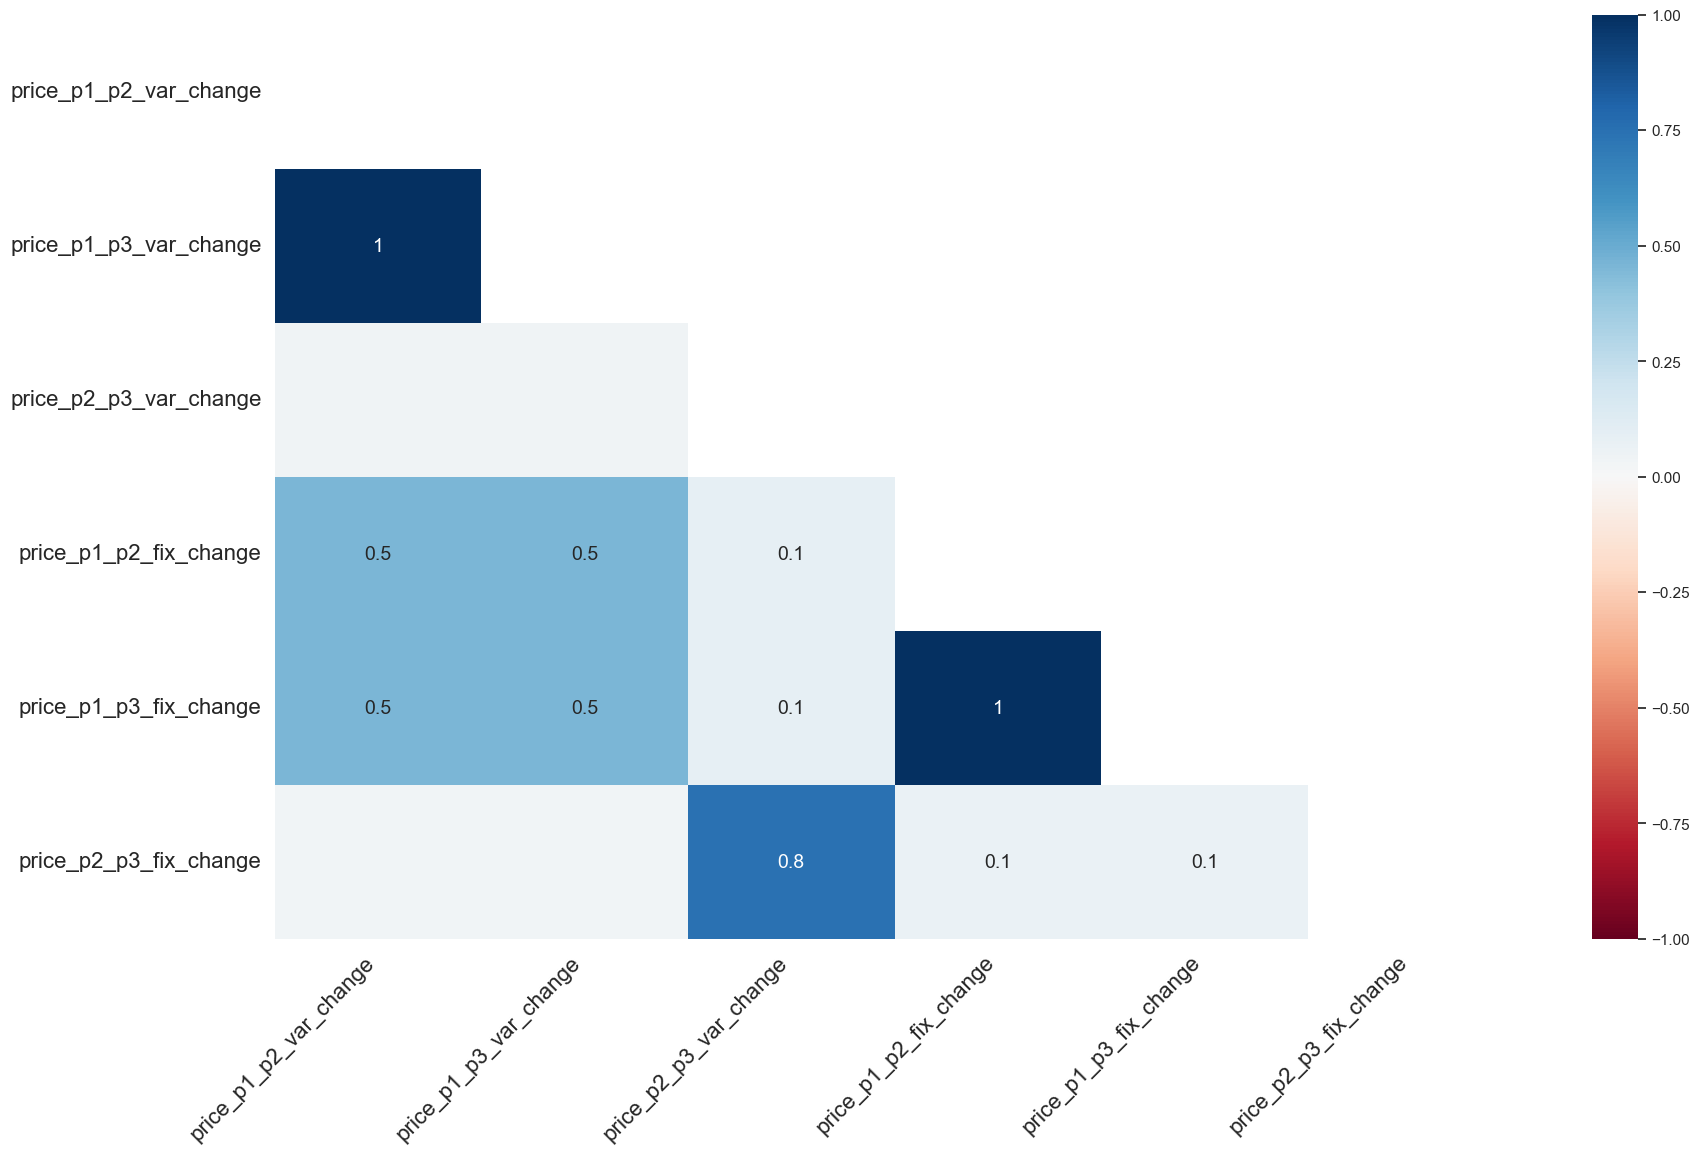

In [60]:
import missingno as msno
msno.heatmap(cleaned_data)
plt.show()

In [61]:
price_cols = [col for col in cleaned_data.columns if 'price' in col and 'diff' not in col and 'date' not in col and 'forecast' not in col]
cleaned_data[price_cols][cleaned_data['price_mid_peak_fix'] == 0].head(20)

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_var,price_fix,price_p1_p2_var_change,price_p1_p3_var_change,price_p2_p3_var_change,price_p1_p2_fix_change,price_p1_p3_fix_change,price_p2_p3_fix_change
11,0.146033,0.085483,0.0,44.266930,0.0,0.0,0.077172,14.755643,-0.414632,-1.0,-1.0,-1.0,-1.0,NaN
12,0.151367,0.000000,0.0,44.266931,0.0,0.0,0.050456,14.755644,-1.000000,-1.0,NaN,-1.0,-1.0,NaN
13,0.151367,0.000000,0.0,44.266931,0.0,0.0,0.050456,14.755644,-1.000000,-1.0,NaN,-1.0,-1.0,NaN
14,0.151367,0.000000,0.0,44.266931,0.0,0.0,0.050456,14.755644,-1.000000,-1.0,NaN,-1.0,-1.0,NaN
15,0.151367,0.000000,0.0,44.266930,0.0,0.0,0.050456,14.755643,-1.000000,-1.0,NaN,-1.0,-1.0,NaN
16,0.151367,0.000000,0.0,44.266930,0.0,0.0,0.050456,14.755643,-1.000000,-1.0,NaN,-1.0,-1.0,NaN
17,0.151367,0.000000,0.0,44.266930,0.0,0.0,0.050456,14.755643,-1.000000,-1.0,NaN,-1.0,-1.0,NaN
18,0.151367,0.000000,0.0,44.266930,0.0,0.0,0.050456,14.755643,-1.000000,-1.0,NaN,-1.0,-1.0,NaN
19,0.146905,0.000000,0.0,44.266930,0.0,0.0,0.048968,14.755643,-1.000000,-1.0,NaN,-1.0,-1.0,NaN
20,0.146033,0.085483,0.0,44.266930,0.0,0.0,0.077172,14.755643,-0.414632,-1.0,-1.0,-1.0,-1.0,NaN


Seems like the missing values in any of the features ending with "change" occur when we divide by 0.

## Model Building and Training
    The goal of this project is to deploy a machine learning model that can detect potential churns of PowerCo's clients.   For the clients that the model predicted to churn, a discount of 20% will be offered as an attempt to prevent customer turnover. As a result, since this is a classification problem, our metric to optimize for will be recall.
                                 recall=TP/TP+FN
     where FN,false negatives, are clients who churned but the model predicted they didn't.

In [62]:
# Check distribution of churn
cleaned_data.churn.value_counts(normalize=True)

0    0.902923
1    0.097077
Name: churn, dtype: float64

In [63]:
print(f'Training: {len(cleaned_data.sample(frac=0.95))}, Testing: {len(cleaned_data.sample(frac=0.05))}')

Training: 166392, Testing: 8757


Since the dataset has many rows, we can get away with training on more data.

In [64]:
# Shuffle order
cleaned_data_shuff = cleaned_data.sample(frac=1).reset_index(drop=True)

In [65]:
# Split into feature data and target label
X = cleaned_data_shuff.drop(['churn'], axis=1)
y = cleaned_data_shuff.churn

X.shape, y.shape

((175149, 74), (175149,))

In [66]:
pd.set_option('display.max_columns', None)
X.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_var,price_fix,total_cons,total_cons_binned,cons_12m_binned,cons_last_month_binned,forecast_cons_year_binned,forecast_cons_12m_binned,imp_cons_binned,net_margin_binned,forecast_meter_rent_12m_binned,margin_gross_pow_ele_binned,margin_net_pow_ele_binned,pow_max_binned,price_p1_p2_var_diff,price_p1_p3_var_diff,price_p2_p3_var_diff,price_p1_p2_fix_diff,price_p1_p3_fix_diff,price_p2_p3_fix_diff,price_p1_p2_var_change,price_p1_p3_var_change,price_p2_p3_var_change,price_p1_p2_fix_change,price_p1_p3_fix_change,price_p2_p3_fix_change,offpeak_diff_dec_january_energy_x,offpeak_diff_dec_january_power_x,contract_duration,next_renewal,days_since_modif_prod,date_activ_year,date_activ_month,date_activ_dow,date_end_year,date_end_month,date_end_dow,date_modif_prod_year,date_modif_prod_month,date_modif_prod_dow,date_renewal_year,date_renewal_month,date_renewal_dow,price_date_year,price_date_month,price_date_dow,offpeak_diff_dec_january_energy_y,offpeak_diff_dec_january_power_y
0,foosdfpfkusacimwkcsosbicdxkicaua,6725,0,0,1004.48,0,0.0,19.53,0.144902,0.000000,44.311378,0,0.00,15.72,15.72,1,99.06,6,ldkssxwpmemidmecebumciepifcamkci,13.200,0.146788,0.000000,0.000000,44.444710,0.000000,0.000000,0.048929,14.814903,6725,"(4947.0, 7685.0]","(4517.0, 6895.0]","(-0.001, 792.0]","(-0.001, 314.0]","(823.24, 1112.61]","(-0.001, 37.39]","(83.86, 112.5]","(18.79, 131.03]","(14.28, 21.64]","(14.28, 21.64]","(12.5, 13.856]",-0.146788,-0.146788,0.000000,-44.444710,-44.444710,0.000000,-1.000000,-1.000000,NaN,-1.0,-1.0,NaN,-0.003423,0.177779,2557,2193,0,2009,8,1,2016,8,3,2009,8,1,2015,8,3,2015,12,1,-0.003423,0.177779
1,foosdfpfkusacimwkcsosbicdxkicaua,302,0,0,62.62,0,0.0,15.65,0.245347,0.168092,53.284378,0,0.00,92.48,92.48,1,64.65,3,lxidpiddsbxsbosboudacockeimpuepw,10.392,0.247170,0.168114,0.000000,53.230930,0.000000,0.000000,0.138428,17.743643,302,"(-0.001, 2682.0]","(-0.001, 2524.0]","(-0.001, 792.0]","(-0.001, 314.0]","(-0.001, 230.87]","(-0.001, 37.39]","(60.5, 83.86]","(-0.001, 16.18]","(29.88, 374.64]","(29.88, 374.64]","(3.299, 12.5]",-0.079056,-0.247170,-0.168114,-53.230930,-53.230930,0.000000,-0.319845,-1.000000,-1.000000,-1.0,-1.0,NaN,-0.004207,0.213779,1461,1096,0,2012,10,2,2016,10,0,2012,10,2,2015,11,6,2015,11,6,-0.004207,0.213779
2,foosdfpfkusacimwkcsosbicdxkicaua,39523,0,2775,388.70,358,0.0,143.65,0.116910,0.100572,40.606701,0,35.49,31.41,31.41,1,47.84,4,lxidpiddsbxsbosboudacockeimpuepw,17.320,0.129444,0.106863,0.075004,40.565969,24.339581,16.226389,0.103770,27.043980,39523,"(38090.0, 71223.6]","(31675.0, 55292.0]","(792.0, 771203.0]","(314.0, 175375.0]","(230.87, 410.73]","(-0.001, 37.39]","(41.32, 60.5]","(131.03, 599.31]","(29.88, 374.64]","(29.88, 374.64]","(13.856, 19.18]",-0.022581,-0.054440,-0.031859,-16.226389,-24.339581,-8.113192,-0.174446,-0.420568,-0.298129,-0.4,-0.6,-0.333333,-0.009528,0.162916,1461,1096,0,2012,5,2,2016,5,0,2012,5,2,2015,5,6,2015,3,6,-0.009528,0.162916
3,usilxuppasemubllopkaafesmlibmsdf,20840,0,0,2575.58,0,0.0,38.28,0.162904,0.085646,44.311378,0,0.00,8.98,8.98,1,159.11,3,lxidpiddsbxsbosboudacockeimpuepw,10.392,0.164895,0.086149,0.000000,44.444710,0.000000,0.000000,0.083681,14.814903,20840,"(16339.0, 24048.0]","(20443.6, 31675.0]","(-0.001, 792.0]","(-0.001, 314.0]","(2049.03, 2888.62]","(-0.001, 37.39]","(147.84, 203.35]","(18.79, 131.03]","(-0.001, 14.28]","(-0.001, 14.28]","(3.299, 12.5]",-0.078746,-0.164895,-0.086149,-44.444710,-44.444710,0.000000,-0.477552,-1.000000,-1.000000,-1.0,-1.0,NaN,-0.004734,0.177779,1461,1096,1017,2012,9,4,2016,9,2,2015,7,6,2015,9,1,2015,12,1,-0.004734

In [67]:
# Columns to transform
categorical_cols = X.select_dtypes(include='category').columns.to_list()
numerical_cols = X.select_dtypes(include='number').columns.to_list()

In [68]:
print(categorical_cols)
print(numerical_cols)

['channel_sales', 'origin_up', 'total_cons_binned', 'cons_12m_binned', 'cons_last_month_binned', 'forecast_cons_year_binned', 'forecast_cons_12m_binned', 'imp_cons_binned', 'net_margin_binned', 'forecast_meter_rent_12m_binned', 'margin_gross_pow_ele_binned', 'margin_net_pow_ele_binned', 'pow_max_binned']
['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'pow_max', 'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix', 'price_var', 'price_fix', 'total_cons', 'price_p1_p2_var_diff', 'price_p1_p3_var_diff', 'price_p2_p3_var_diff', 'price_p1_p2_fix_diff', 'price_p1_p3_fix_diff', 'price_p2_p3_fix_diff', 'price_p1_p2_var_

In [71]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [72]:
# Function for creating a pipeline, cross-validating, and plotting the PR curve
def test_pipeline(X, y, test_size, model):
    # Since churn is an imbalanced class, we include the stratify argument to balance the splits evenly
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    ct = ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical_cols),
        ('scale', StandardScaler(), numerical_cols),
    ])

    pipe = Pipeline([
        ('ct', ct),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
        ('model', model)
    ])
    cv = cross_validate(pipe, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)
    avg_scores = np.mean(cv.get('test_score'))
    std_scores = np.std(cv.get('test_score'))
    print(f'{model}\nAvg recall: {avg_scores}, Std: {std_scores}')

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(confusion_matrix(y_test, y_pred))

    # Plot PR curve
    y_prob = pipe.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:, 1])  # Probabilites for positive class
    plt.plot(recall, precision)
    plt.title('Precision Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    return pipe

LogisticRegression(solver='sag')
Avg recall: 0.007057414275739697, Std: 0.0006056546955916622


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[[15796    19]
 [ 1688    12]]


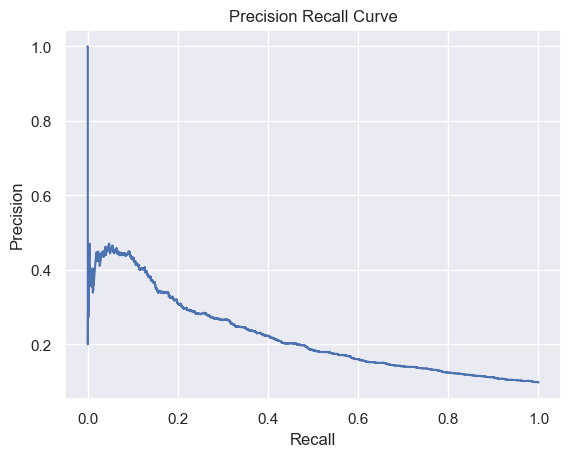

In [73]:
# Logistic regression
lr_pipe = test_pipeline(X, y, test_size=0.1, model=LogisticRegression(solver='sag'))

KNeighborsClassifier()
Avg recall: 0.9757388341224031, Std: 0.002557281651681216


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[[31599    30]
 [   54  3347]]


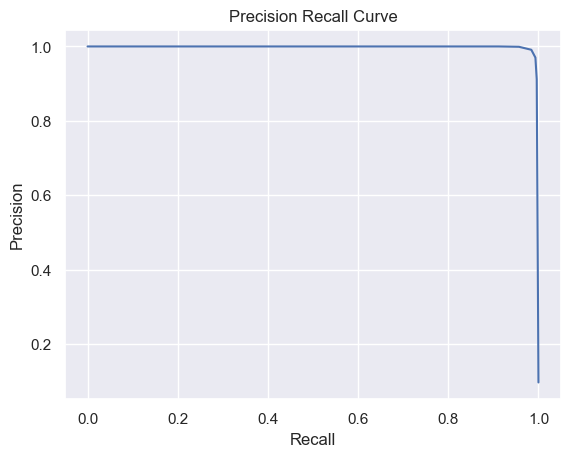

In [74]:
# KNN
knn_pipe = test_pipeline(X, y, test_size=0.2, model=KNeighborsClassifier())

RandomForestClassifier()
Avg recall: 0.9990442527617441, Std: 0.0003748219561921567
[[31629     0]
 [    2  3399]]


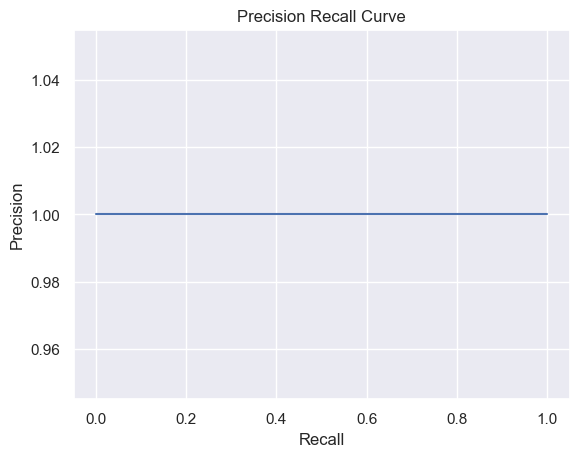

In [75]:
# Random forest
rf_pipe = test_pipeline(X, y, test_size=0.2, model=RandomForestClassifier())

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
recall_score(y_test, y_pred)

0.9988235294117647

## Model Tuning

In [77]:
def build_pipeline(model):
    ct = ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical_cols),
        ('scale', StandardScaler(), numerical_cols),
    ])

    pipe = Pipeline([
        ('ct', ct),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
        ('model', model)
    ])
    return pipe

In [78]:
rf_pipe = build_pipeline(model=RandomForestClassifier(n_jobs=-1))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

param_grid = {
    'model__n_estimators': np.arange(100, 301, 50),
    'model__max_depth': [300, 500, None],
    'model__max_features': ['sqrt', 'log2'],
}
gs = RandomizedSearchCV(rf_pipe, param_distributions=param_grid, cv=5, scoring='recall', n_jobs=-1, random_state=42)
gs.fit(X_train, y_train)
gs.best_params_

{'model__n_estimators': 250,
 'model__max_features': 'sqrt',
 'model__max_depth': None}

In [80]:
gs.best_score_


0.9994118928198524

In [81]:
recall_score(y_test, gs.predict(X_test))

0.9994117647058823

In [82]:
best_model = gs.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
recall_score(y_test, y_pred)

0.9994117647058823

In [83]:
# Probabilites of not churning, probabilities of churning
probabilities = best_model.predict_proba(X_test)
probabilities

array([[1.   , 0.   ],
       [0.996, 0.004],
       [1.   , 0.   ],
       ...,
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ]])

In [84]:
X_test.reset_index(drop=True, inplace=True)
X_test['churn'] = y_pred
X_test['churn_probability'] = probabilities[:, 1]
X_test.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_var,price_fix,total_cons,total_cons_binned,cons_12m_binned,cons_last_month_binned,forecast_cons_year_binned,forecast_cons_12m_binned,imp_cons_binned,net_margin_binned,forecast_meter_rent_12m_binned,margin_gross_pow_ele_binned,margin_net_pow_ele_binned,pow_max_binned,price_p1_p2_var_diff,price_p1_p3_var_diff,price_p2_p3_var_diff,price_p1_p2_fix_diff,price_p1_p3_fix_diff,price_p2_p3_fix_diff,price_p1_p2_var_change,price_p1_p3_var_change,price_p2_p3_var_change,price_p1_p2_fix_change,price_p1_p3_fix_change,price_p2_p3_fix_change,offpeak_diff_dec_january_energy_x,offpeak_diff_dec_january_power_x,contract_duration,next_renewal,days_since_modif_prod,date_activ_year,date_activ_month,date_activ_dow,date_end_year,date_end_month,date_end_dow,date_modif_prod_year,date_modif_prod_month,date_modif_prod_dow,date_renewal_year,date_renewal_month,date_renewal_dow,price_date_year,price_date_month,price_date_dow,offpeak_diff_dec_january_energy_y,offpeak_diff_dec_january_power_y,churn,churn_probability
0,MISSING,7197,0,1372,764.89,1372,0.0,131.12,0.115237,0.100123,40.939027,1,142.45,22.28,22.28,3,85.03,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,15.100,0.118238,0.101781,0.074205,41.062219,24.770664,16.624889,0.098075,27.485924,7197,"(4947.0, 7685.0]","(6895.0, 9898.0]","(792.0, 771203.0]","(314.0, 175375.0]","(592.552, 823.24]","(37.39, 15042.79]","(83.86, 112.5]","(131.03, 599.31]","(21.64, 29.88]","(21.64, 29.88]","(13.856, 19.18]",-0.016457,-0.044033,-0.027576,-16.291555,-24.43733,-8.145775,-0.139185,-0.37241,-0.270935,-0.396753,-0.595129,-0.328848,-0.009328,0.496249,2557,2197,0,2009,9,0,2016,9,2,2009,9,0,2015,9,6,2015,12,1,-0.009328,0.496249,0,0.000
1,foosdfpfkusacimwkcsosbicdxkicaua,55264,0,0,4107.16,0,0.0,19.97,0.142996,0.000000,44.311378,0,0.00,29.64,29.64,1,389.54,3,lxidpiddsbxsbosboudacockeimpuepw,13.164,0.141390,0.000000,0.000000,44.444710,0.000000,0.000000,0.047130,14.814903,55264,"(38090.0, 71223.6]","(31675.0, 55292.0]","(-0.001, 792.0]","(-0.001, 314.0]","(2888.62, 4507.49]","(-0.001, 37.39]","(297.08, 466.08]","(18.79, 131.03]","(21.64, 29.88]","(21.64, 29.88]","(12.5, 13.856]",-0.141390,-0.141390,0.000000,-44.444710,-44.44471,0.000000,-1.000000,-1.00000,NaN,-1.000000,-1.000000,NaN,-0.000510,0.000000,1095,735,1045,2013,2,0,2016,2,3,2015,12,2,2015,2,0,2015,8,5,-0.000510,0.000000,0,0.004
2,usilxuppasemubllopkaafesmlibmsdf,7799,0,0,918.79,0,0.0,0.00,0.160012,0.082114,44.311378,0,0.00,34.68,34.68,1,84.75,4,lxidpiddsbxsbosboudacockeimpuepw,13.856,0.163071,0.084016,0.000000,44.266930,0.000000,0.000000,0.082362,14.755643,7799,"(7685.0, 11315.0]","(6895.0, 9898.0]","(-0.001, 792.0]","(-0.001, 314.0]","(823.24, 1112.61]","(-0.001, 37.39]","(83.86, 112.5]","(-0.001, 16.18]","(29.88, 374.64]","(29.88, 374.64]","(12.5, 13.856]",-0.079055,-0.163071,-0.084016,-44.266930,-44.26693,0.000000,-0.484789,-1.00000,-1.000000,-1.000000,-1.000000,NaN,-0.005351,-0.000001,1530,1169,1478,2011,11,0,2016,2,4,2015,12,1,2015,2,0,2015,9,1,-0.005351,-0.000001,0,0.000
3,MISSING,670633,0,75409,2012.32,0,0.0,16.26,0.162033,0.084138,44.311378,0,0.00,32.64,32.64,1,292.25,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,14.500,0.168654,0.085390,0.000000,44.444710,0.000000,0.000000,0.084681,14.814903,670633,"(297785.0, 6799539.0]","(221806.0, 6207104.0]","(792.0, 771203.0]","(-0.001, 314.0]","(1491.15, 2049.03]","(-0.001, 37.39]","(203.35, 297.08]","(16.18, 18.79]","(29.88, 374.64]","(29.88, 374.64]","(13.856, 19.18]",-0.083264,-0.168654,-0.085390,-44.444710,-44.44471,0.000000,-0.493697,-1.00000,-1.000000,-1.000000,-1.000000,NaN,-0.004679,0.177779,2191

In [85]:
X_test.churn_probability.mean()

0.09699571795603504

In [86]:
import pickle
pickle.dump(best_model,open('Model_Powerco.pkl','wb'))